# SPEECH EMOTION RECOGNITION

In [2]:
#Import Libraries

import numpy as np
import pandas as pd 

import os
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import librosa   # For audio analysis
import librosa.display

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn import preprocessing

from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from keras.utils import to_categorical
from keras import callbacks
from keras.utils import np_utils
from keras.utils import np_utils

from tqdm import tqdm
from IPython.display import Audio, display

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load the Data

files_Path='../input/speech-emotion-recognition-en/Crema/'

c_emotions = {
    'NEU':'neutral',
    'HAP':'happy',
    'SAD':'sad',
    'ANG':'angry',
    'FEA':'fear',
    'DIS':'disgust'}

c_file = []
for wav in os.listdir(files_Path):
    emo = wav.partition(".wav")[0].split('_')
    emotion = c_emotions[emo[2]]
    c_file.append((files_Path+'/'+wav,emotion))
    
data_df = pd.DataFrame(c_file, columns = ['File_path', 'Emotion'])
data_df.to_csv('data_df.csv')
data_df.shape
data_df.head(10)    

,File_path,Emotion
0,../input/speech-emotion-recognition-en/Crema//...,disgust
1,../input/speech-emotion-recognition-en/Crema//...,happy
2,../input/speech-emotion-recognition-en/Crema//...,happy
3,../input/speech-emotion-recognition-en/Crema//...,disgust
4,../input/speech-emotion-recognition-en/Crema//...,disgust
5,../input/speech-emotion-recognition-en/Crema//...,disgust
6,../input/speech-emotion-recognition-en/Crema//...,happy
7,../input/speech-emotion-recognition-en/Crema//...,sad
8,../input/speech-emotion-recognition-en/Crema//...,disgust
9,../input/speech-emotion-recognition-en/Crema//...,sad


# Data Analysis

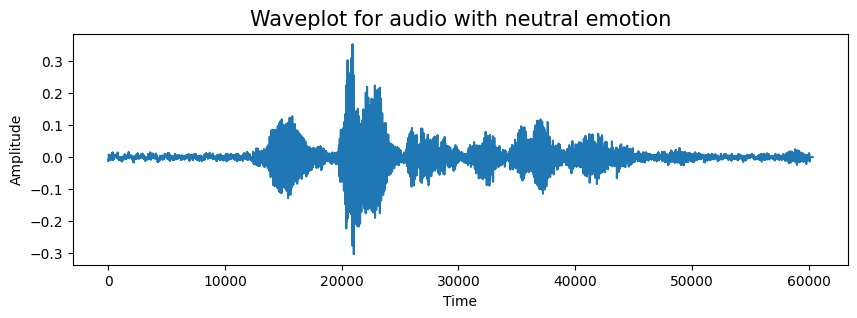

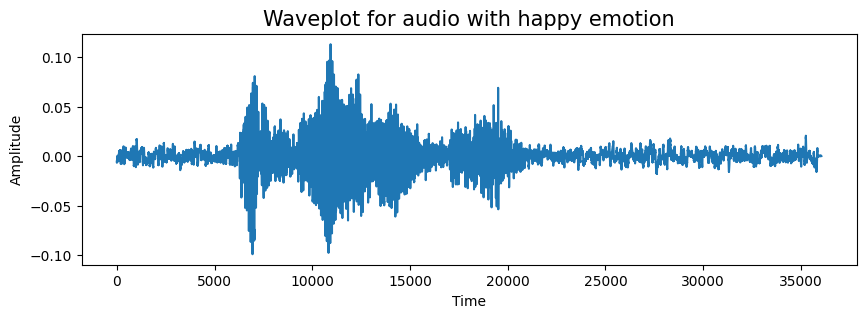

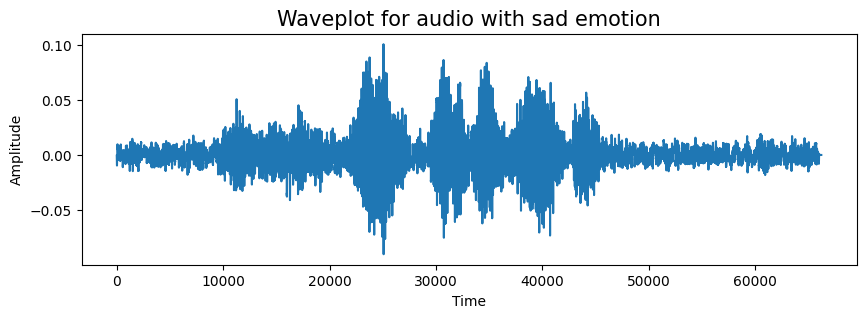

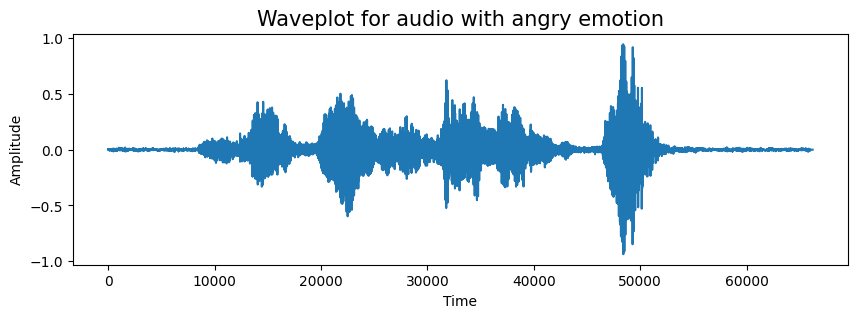

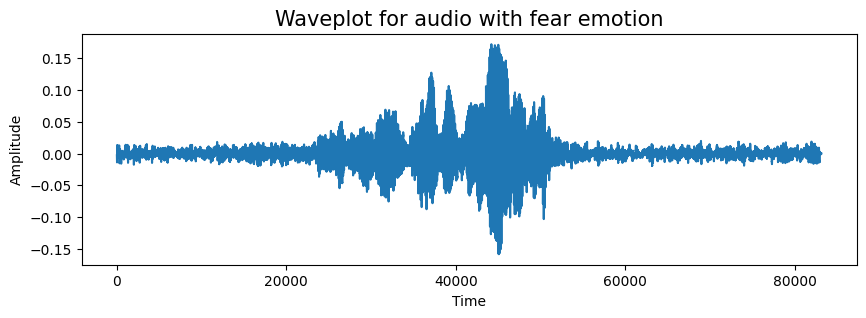

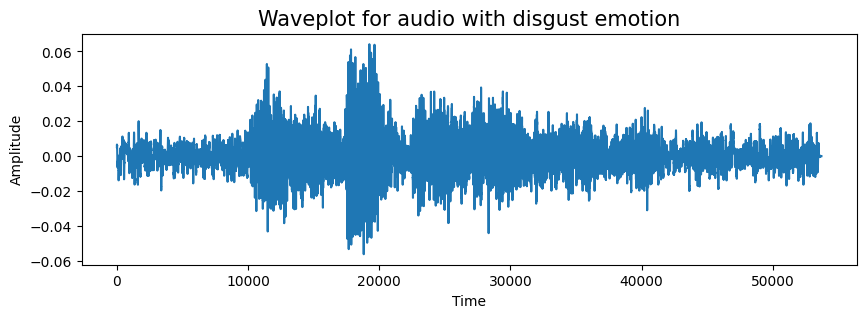

In [4]:
def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {emotion} emotion', size=15)
    plt.plot(data)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.show()

for emotion in c_emotions.values():
    # get the path of the first happy record
    path = (data_df[data_df.Emotion == emotion].iloc[0])[0]
    data, sampling_rate = librosa.load(path)
    create_waveplot(data,sampling_rate,emotion)
    # create_spectrogram(data, sampling_rate, emotion)
    display(Audio(path))


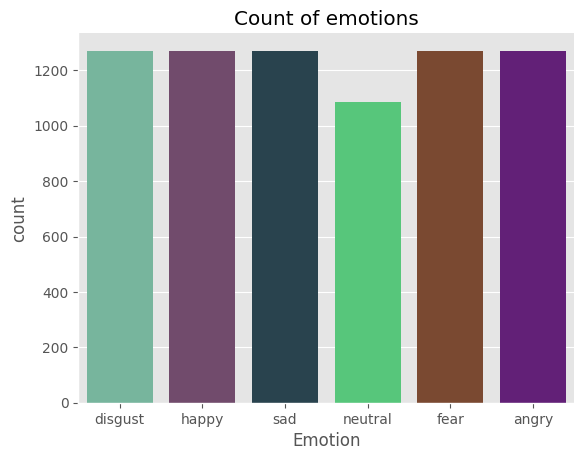

In [5]:
plt.style.use("ggplot")
cols= ["#6dbf9f","#774571","#234554","#45d874","#864525","#691285"]
plt.title("Count of emotions")
sns.countplot(x = data_df["Emotion"], palette= cols)
sns.despine(top = True, right = True, left = False, bottom = False)

note: the data seems to be somewhat balanced.


# Data Processing

In [5]:
# adding random noise to the data, and returning the augmented audio data.
def add_noise(data,random=False,rate=0.035,threshold=0.075):
    if random:
        rate=np.random.random()*threshold
    noise=rate*np.random.uniform()*np.amax(data)
    augmented_data=data+noise*np.random.normal(size=data.shape[0])
    return augmented_data


# applying pitch shifting to the input audio data.
def pitching(data,sr,pitch_factor=0.7,random=False):
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data,sr=sr,n_steps=pitch_factor)


# Computint the zero-crossing rate feature for the input audio data using the librosa library.
def zcr(data,frame_length,hop_length):
    zcr=librosa.feature.zero_crossing_rate(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(zcr)
# Computing the root mean square energy feature for the input audio data using the librosa library.
def rmse(data,frame_length=2048,hop_length=512):
    rmse=librosa.feature.rms(y=data,frame_length=frame_length,hop_length=hop_length)
    return np.squeeze(rmse)
# Computing Mel-frequency cepstral coefficients (MFCCs) for the input audio data using the librosa library. 
# It can return the MFCCs flattened or as a matrix.
def mfcc(data,sr,frame_length=2048,hop_length=512,flatten:bool=True):
    mfcc=librosa.feature.mfcc(y=data,sr=sr)
    return np.squeeze(mfcc.T)if not flatten else np.ravel(mfcc.T)


# Extracts a set of audio features, including zero-crossing rate, root mean square energy, and MFCCs, 
# from the input audio data and returns them as a concatenated feature vector.
def extract_features(data,sr,frame_length=2048,hop_length=512):
    result=np.array([])
    
    result=np.hstack((result,
                      zcr(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      mfcc(data,sr,frame_length,hop_length)
                     ))
    return result

def get_features(path,duration=2.5, offset=0.6):
    data,sr=librosa.load(path,duration=duration,offset=offset)
    aud=extract_features(data,sr)
    audio=np.array(aud)
    
    noised_audio=add_noise(data,random=True)
    aud2=extract_features(noised_audio,sr)
    audio=np.vstack((audio,aud2))
    
    pitched_audio=pitching(data,sr,random=True)
    aud3=extract_features(pitched_audio,sr)
    audio=np.vstack((audio,aud3))
    
    return audio



X, Y = [], []

for path, emotion, index in zip(data_df.File_path, data_df.Emotion, range(data_df.File_path.shape[0])):
    features = get_features(path)
    if index % 500 == 0:
        print(f'{index} audio has been processed')
    for i in features:
        X.append(i)
        Y.append(emotion)

print('Done')


0 audio has been processed
500 audio has been processed
1000 audio has been processed
1500 audio has been processed
2500 audio has been processed
3000 audio has been processed
3500 audio has been processed
4000 audio has been processed
4500 audio has been processed
5000 audio has been processed
5500 audio has been processed
6000 audio has been processed
6500 audio has been processed
7000 audio has been processed
Done


In [6]:
processed_data_path='./processed_data.csv'

In [ ]:
extract=pd.DataFrame(X)
extract['Emotion']=Y
extract.to_csv(processed_data_path,index=False)
extract.head(10)

In [7]:
df=pd.read_csv(processed_data_path)
df.shape

df=df.fillna(0)
print(df.isna().any())
df.shape

0          False
1          False
2          False
3          False
4          False
           ...  
2372       False
2373       False
2374       False
2375       False
Emotion    False
Length: 2377, dtype: bool


(22326, 2377)

In [8]:
df.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,Emotion
22316,0.026855,0.036621,0.052734,0.063477,0.077148,0.086914,0.098633,0.095703,0.078125,0.067871,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
22317,0.017090,0.029785,0.037109,0.039062,0.042969,0.043457,0.048828,0.050781,0.052734,0.061035,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
22318,0.151367,0.257812,0.345703,0.344238,0.287598,0.196777,0.124512,0.061523,0.057617,0.063965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
22319,0.014160,0.022949,0.031250,0.035645,0.042480,0.049316,0.054688,0.057129,0.058594,0.062500,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,angry
22320,0.022949,0.037598,0.047363,0.045410,0.043945,0.047363,0.049316,0.046387,0.042480,0.029785,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad
22321,0.024902,0.040527,0.051270,0.052246,0.051758,0.054199,0.055176,0.048340,0.043457,0.031738,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad
22322,0.022949,0.036133,0.049805,0.046875,0.044434,0.048340,0.043945,0.041992,0.039062,0.027344,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,sad
22323,0.018555,0.022949,0.032227,0.038086,0.032227,0.037109,0.032715,0.028320,0.032715,0.029785,...,-6.634636,1.850791,-11.791023,1.025090,-10.967024,3.134825,-11.317006,-3.286223,-1.118858,sad
22324,0.050781,0.057129,0.076172,0.077148,0.069336,0.076172,0.067871,0.056641,0.064941,0.067871,...,0.570297,-1.703944,-10.021447,-7.541332,-3.482001,-0.668859,-8.239145,-6.389553,0.989601,sad
22325,0.015625,0.023926,0.032715,0.034668,0.030762,0.033691,0.033691,0.037598,0.040527,0.038086,...,-4.793972,0.163046,-9.078397,0.920113,-10.382425,5.430383,-11.036170,-9.162048,-5.097025,sad


In [10]:
X=df.drop(labels='Emotion',axis=1)
Y=df['Emotion']
lb=LabelEncoder()
Y=np_utils.to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

# Splitting the data into Train and Test set of 80-20, and Train and Validation set of 90-10.

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=32,test_size=0.2,shuffle=True)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=32,test_size=0.1,shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape,y_test.shape,y_val.shape

((16074, 2376), (4466, 2376), (1786, 2376), (16074, 6), (4466, 6), (1786, 6))

In [12]:
# Fit and Transform data using StandardScaler Technique.

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)
X_val=scaler.transform(X_val)
X_train.shape,X_test.shape,X_val.shape,y_train.shape,y_test.shape,y_val.shape

((16074, 2376), (4466, 2376), (1786, 2376), (16074, 6), (4466, 6), (1786, 6))

In [13]:
# Adding an extra dimension to making data 3D from 2D cause CNN expects 3D input.

X_train=np.expand_dims(X_train,axis=2)
X_val=np.expand_dims(X_val,axis=2)
X_test=np.expand_dims(X_test,axis=2)
X_train.shape, X_test.shape, X_val.shape

((16074, 2376, 1), (4466, 2376, 1), (1786, 2376, 1))

# Model Building

In [14]:
import tensorflow.keras.layers as L
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau # to adjust learning rate dynamically

# Setting up the callbacks.
early_stop = callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=0.00001)

# defining the epochs and batch_size.
EPOCH=50
BATCH_SIZE=30

# CNN model is defined using Sequential.
    
model=tf.keras.Sequential([
    L.Conv1D(32,kernel_size=6, strides=1,padding='same', activation='relu',input_shape=(X_train.shape[1],1)),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(64,kernel_size=6,strides=1,padding='same',activation='relu'),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Conv1D(128,kernel_size=6,strides=1,padding='same',activation='relu'),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    L.Flatten(),
    L.Dense(256,activation='relu'),
    L.Dropout(0.5),
    L.Dense(6,activation='softmax')
])

# Compiling the model using 'nadam' optimizer, 'catergorical crossentropy' as  loss function and 'accuracy' metrics.
model.compile(optimizer='nadam',loss='categorical_crossentropy',metrics='accuracy')

# Training the model using model.fit() method.
history = model.fit(X_train, y_train, epochs=EPOCH, validation_data=(X_val,y_val), batch_size=BATCH_SIZE, callbacks=[early_stop,lr_reduction])

Epoch 1/50
536/536 [==============================] - 10s 11ms/step - loss: 1.5593 - accuracy: 0.3656 - val_loss: 1.4160 - val_accuracy: 0.4278 - lr: 0.0010
Epoch 2/50
536/536 [==============================] - 5s 10ms/step - loss: 1.4355 - accuracy: 0.4181 - val_loss: 1.3518 - val_accuracy: 0.4552 - lr: 0.0010
Epoch 3/50
536/536 [==============================] - 5s 10ms/step - loss: 1.3712 - accuracy: 0.4479 - val_loss: 1.3391 - val_accuracy: 0.4608 - lr: 0.0010
Epoch 4/50
536/536 [==============================] - 6s 11ms/step - loss: 1.3301 - accuracy: 0.4650 - val_loss: 1.2819 - val_accuracy: 0.4882 - lr: 0.0010
Epoch 5/50
536/536 [==============================] - 6s 10ms/step - loss: 1.2727 - accuracy: 0.4935 - val_loss: 1.2818 - val_accuracy: 0.4793 - lr: 0.0010
Epoch 6/50
536/536 [==============================] - 5s 10ms/step - loss: 1.2061 - accuracy: 0.5232 - val_loss: 1.1793 - val_accuracy: 0.5095 - lr: 0.0010
Epoch 7/50
536/536 [==============================] - 5s 10ms/s

In [15]:
# Calculating the mean validation accuracy.

val_accuracy = np.mean(history.history['val_accuracy'])
print("\n%s: %.2f%%" % ('val_accuracy', val_accuracy*100))


val_accuracy: 65.64%


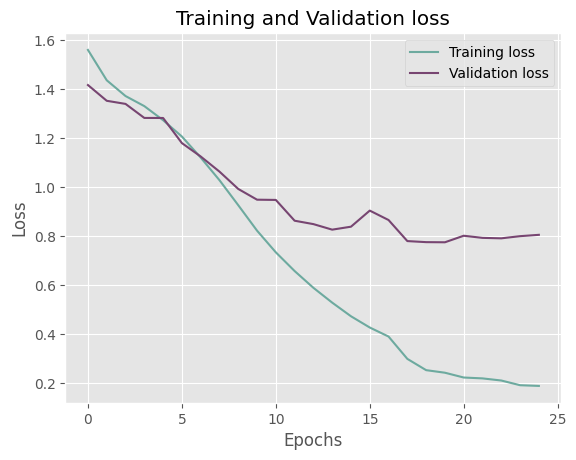

In [16]:
# Visualization of Training and Validation Loss over epochs.

history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['loss']], "#6daa9f", label='Training loss')
plt.plot(history_df.loc[:, ['val_loss']],"#774571", label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")

plt.show()

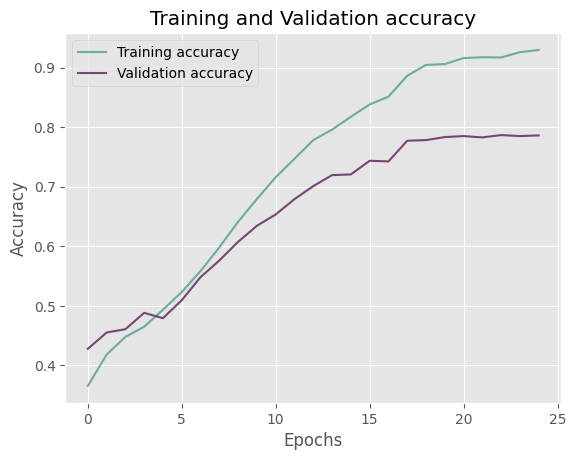

In [17]:
# Visualization of Training and Validation Accuracy over epochs.

history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
# Predicting the test set results

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)
np.set_printoptions()

140/140 [==============================] - 1s 3ms/step


# Conclusion

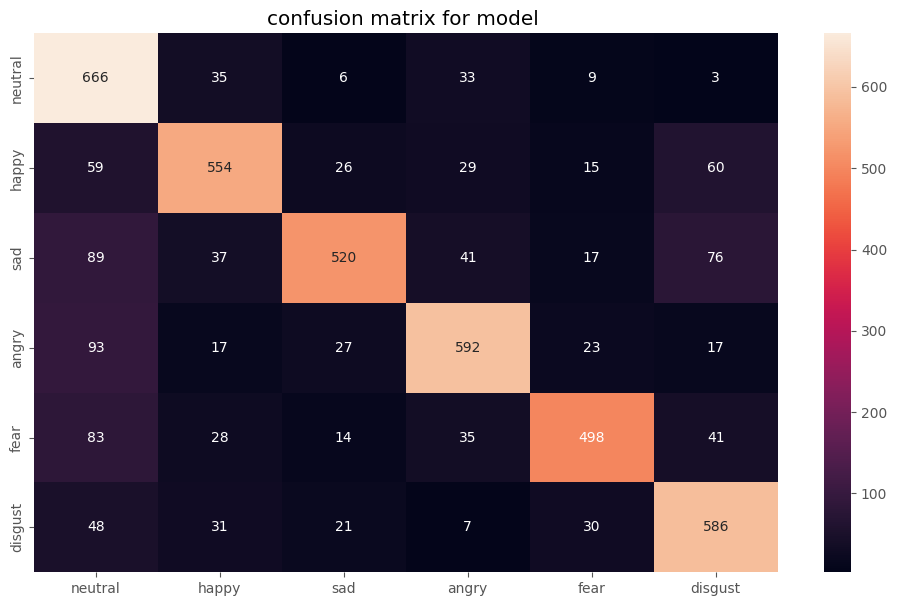

In [19]:
import seaborn as sns
# confusion matrix
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
conf=confusion_matrix(y_test_labels,y_pred_labels)
cmap1 = sns.diverging_palette(275,100,  s=40, l=65, n=6)
cm=pd.DataFrame(
    conf,index=[i for i in c_emotions.values()],
    columns=[i for i in c_emotions.values()]
)
plt.figure(figsize=(12,7))
ax=sns.heatmap(cm,annot=True,fmt='d')
ax.set_title(f'confusion matrix for model ')
plt.show()

# Saving the model

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2376, 32)          224       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1188, 32)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 1188, 64)          12352     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 594, 64)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 594, 128)          49280     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 297, 128)         0

In [ ]:
# Saving the entire model in a file including architecture and weights
path = '/kaggle/working/speech-emotion-recognition.h5'
model.save(path)

In [27]:
# Loading the saved model

from tensorflow.keras.models import load_model

loaded_model = load_model('/kaggle/working/speech-emotion-recognition.h5')

# we can make prediction using the loaded_model.predict() function.